In [1]:
import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
num_features = 5
num_samples = 5000
anomaly_fraction = 0.1
anomaly_magnitude = 10

# Mean and covariance matrix
mean = np.zeros(num_features)
cov = 0.5 * np.identity(num_features)


# Generate normal data
data = np.random.multivariate_normal(mean, cov, num_samples)

# Determine indices for anomalies
num_anomalies = int(num_samples * anomaly_fraction)
anomaly_indices = np.random.choice(num_samples, num_anomalies, replace=False)

# Introduce anomalies in multiple features
for idx in anomaly_indices:
    feature_to_anomaly = np.random.choice(num_features, 2, replace=False)  # Choose 2 features to add anomaly
    data[idx, feature_to_anomaly] += anomaly_magnitude  # Add anomaly magnitude to selected features

# Create a label column to mark anomalies
labels = np.zeros(num_samples)
labels[anomaly_indices] = 1  # Mark anomalies with 1

# Create DataFrame
df = pd.DataFrame(data, columns=[f'Feature_{i+1}' for i in range(num_features)])
df['Anomaly'] = labels

# Save to Excel
df.to_excel('updated_simulated_dataset.xlsx', index=False)


In [2]:
print(mean)
print(cov)
print(data.shape)
print(len(anomaly_indices))

[0. 0. 0. 0. 0.]
[[0.5 0.  0.  0.  0. ]
 [0.  0.5 0.  0.  0. ]
 [0.  0.  0.5 0.  0. ]
 [0.  0.  0.  0.5 0. ]
 [0.  0.  0.  0.  0.5]]
(5000, 5)
500


First few rows of the dataset:
   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Anomaly
0   0.351230  -0.097768   0.457985   1.076945  -0.165571      0.0
1   9.834440  11.116672   0.542658  -0.331969   0.383648      1.0
2  -0.327686  -0.329321   0.171093  -1.352893  -1.219701      0.0
3  -0.397597  -0.716180   0.222206   9.357930   9.001350      1.0
4   1.036370   9.840352   0.047750   8.992551  -0.384937      1.0

Summary statistics:
         Feature_1    Feature_2    Feature_3    Feature_4    Feature_5  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean      0.414915     0.401723     0.382547     0.374276     0.429681   
std       2.110657     2.057436     2.075334     2.054268     2.135609   
min      -2.773556    -2.608068    -2.570475    -2.339038    -2.726869   
25%      -0.451656    -0.428516    -0.481365    -0.461533    -0.439963   
50%       0.042198     0.031010     0.028513     0.034419     0.037637   
75%       0.580047     0.548282   

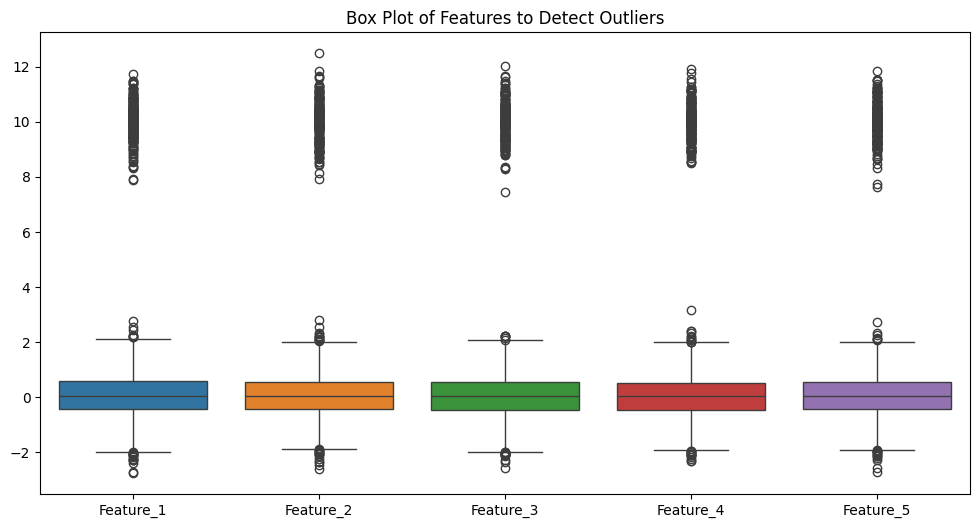

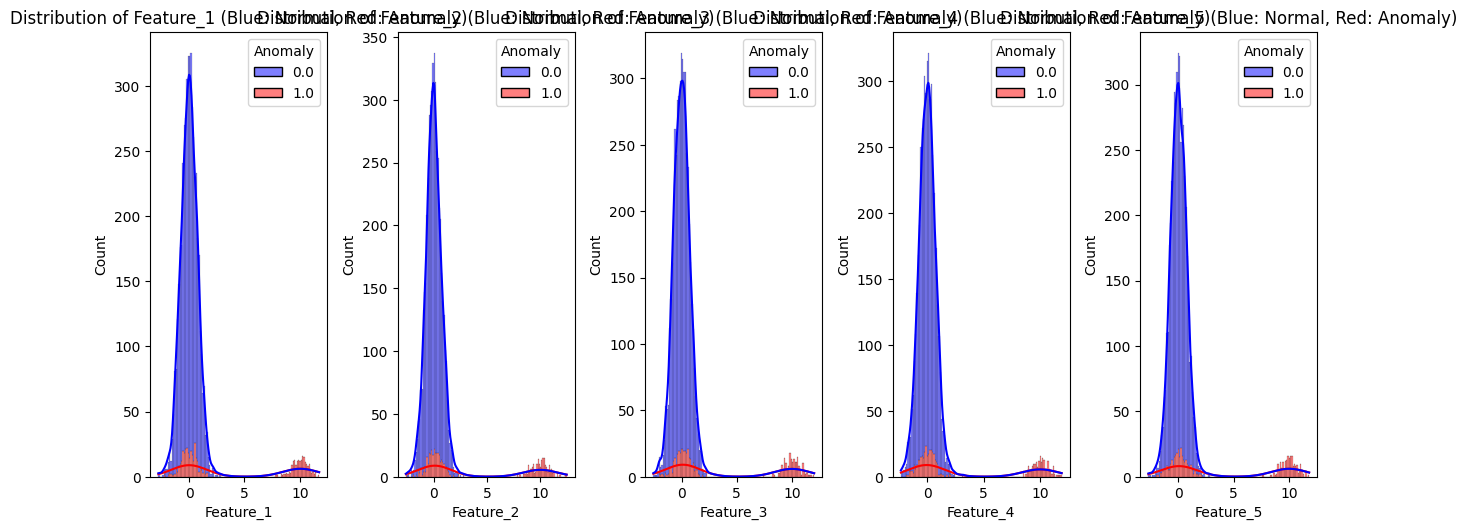

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Display the first few rows
print("First few rows of the dataset:")
print(df.head())

# Summary statistics
print("\nSummary statistics:")
print(df.describe())

# Count of anomalies
print("\nCount of anomalies:")
print(df['Anomaly'].value_counts())

# Box Plot for each feature to visualize outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df.drop(columns=['Anomaly']))
plt.title("Box Plot of Features to Detect Outliers")
plt.show()

# Extract feature columns
features = [col for col in df.columns if 'Feature' in col]

# Plot the distribution of each feature, separating anomalies and normal data
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2,6, i)
    sns.histplot(data=df, x=feature, kde=True, hue="Anomaly", multiple="stack", palette={0: 'blue', 1: 'red'})
    plt.title(f"Distribution of {feature} (Blue: Normal, Red: Anomaly)")

plt.tight_layout()
plt.show()

# # Scatter Plot to visualize anomalies in 2D
# plt.figure(figsize=(10, 6))
# for feature in features:
#     sns.scatterplot(data=df, x=features[0], y=feature, hue='Anomaly', palette={0: 'blue', 1: 'red'}, legend="full")
#     plt.title(f"Scatter Plot with {features[0]} vs {feature}")
#     plt.xlabel(features[0])
#     plt.ylabel(feature)
#     plt.show()


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Feature_1  5000 non-null   float64
 1   Feature_2  5000 non-null   float64
 2   Feature_3  5000 non-null   float64
 3   Feature_4  5000 non-null   float64
 4   Feature_5  5000 non-null   float64
 5   Anomaly    5000 non-null   float64
dtypes: float64(6)
memory usage: 234.5 KB


In [5]:
import numpy as np
import pandas as pd

data = df.iloc[:, :-1].values # Exclude the anomaly label column
true_anomalies = df['Anomaly'].values  # Ground truth

# Compute sample covariance matrix M
M = np.cov(data, rowvar=False)


In [6]:
len(true_anomalies)

5000

In [7]:
M

array([[4.45487436, 0.87368504, 0.87710332, 0.73414659, 0.99836006],
       [0.87368504, 4.23304333, 1.04743135, 0.65991506, 0.84617153],
       [0.87710332, 1.04743135, 4.30701124, 0.77914745, 0.75697041],
       [0.73414659, 0.65991506, 0.77914745, 4.22001868, 1.04067417],
       [0.99836006, 0.84617153, 0.75697041, 1.04067417, 4.56082686]])

In [8]:
def solve_theta_custom(decomp, mu_1):
    eigval, eigvec = np.linalg.eigh(decomp)
    eigval_shifted = eigval + np.sqrt(np.square(eigval) + 4 * mu_1)
    theta_matrix = eigvec @ np.diag(eigval_shifted / (2 * mu_1)) @ eigvec.T
    return theta_matrix

def project_positive_semidefinite(A):
    eigval, eigvec = np.linalg.eigh(A)
    eigval_clipped = np.clip(eigval, 0, None)
    return eigvec @ np.diag(eigval_clipped) @ eigvec.T

def soft_thresholding(matrix, threshold):
    return np.sign(matrix) * np.maximum(np.abs(matrix) - threshold, 0)


In [9]:
def robust_graphical_lasso(M, rho, lambda_, max_iter=1000, epsilon=1e-7):
    # Initialization
    shape = M.shape
    theta = np.zeros(shape)
    S = np.zeros(shape)
    L = M.copy()
    U_1, U_2 = np.zeros(shape), np.zeros(shape)

    mu_1, mu_2 = 0.2, 0.2

    for iteration in range(max_iter):
        # Step 1: Solve for theta
        theta_decomp = mu_1 * (U_1 - theta) - L
        theta = solve_theta_custom(theta_decomp, mu_1)

        # Step 2: Soft-threshold Z and update
        Z = soft_thresholding(theta + U_1, rho / mu_1)

        # Step 3: Solve for L and project onto positive semidefinite cone
        L_temp = M - S + (1 / mu_2) * U_2
        L = project_positive_semidefinite(L_temp)

        # Step 4: Update S using soft thresholding
        S_target = M - L + (1 / mu_2) * U_2
        S = soft_thresholding(S_target, lambda_ / mu_2)

        # Update dual variables
        U_1 += theta - Z
        U_2 += M - L - S

        # Check convergence criteria
        if iteration > 1:
            diff_theta = np.linalg.norm(theta - theta_temp, 'fro')**2 / (np.linalg.norm(theta_temp, 'fro')**2)
            residual = np.linalg.norm(M - L - S, 'fro')**2 / (np.linalg.norm(M, 'fro')**2)
            if diff_theta < epsilon and residual < epsilon:
                break

        # Adjust parameters and save state for the next iteration
        mu_1 *= 1.2
        mu_2 *= 1.2
        theta_temp = theta.copy()

    return theta, S, L, iteration


In [10]:
# Set parameters (tune as needed)
rho = 0.1
lambda_ = 0.1

# Run robust graphical lasso
theta, S, L, iterations = robust_graphical_lasso(M, rho, lambda_)

print("Theta matrix (Precision):\n", theta)
print("Sparse Matrix S (Anomalies):\n", S)
print("Low-Rank Matrix L (Clean data):\n", L)
print("Iterations:", iterations)


Theta matrix (Precision):
 [[ 4.34324628e-40  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  4.34324628e-40  6.50399047e-57 -2.01538397e-56
  -1.19630029e-56]
 [ 0.00000000e+00  1.49272156e-56  4.34324628e-40  3.05089099e-55
   1.73639821e-56]
 [ 0.00000000e+00 -1.36821625e-56  2.99784634e-55  4.34324628e-40
   8.14054743e-56]
 [ 0.00000000e+00 -1.63387881e-56  2.24087677e-56  6.39491164e-56
   4.34324628e-40]]
Sparse Matrix S (Anomalies):
 [[1.56319402e-13 6.29718500e-13 6.11954931e-13 2.19602114e-13
  4.92716978e-13]
 [6.29607477e-13 4.38760139e-13 7.01882996e-13 4.29434266e-13
  7.13429316e-13]
 [6.11843909e-13 7.01660952e-13 7.44293516e-13 4.24993374e-13
  6.66688926e-13]
 [2.19158025e-13 4.29323244e-13 4.24993374e-13 5.90638649e-13
  1.05537801e-12]
 [4.92605956e-13 7.13762383e-13 6.66466882e-13 1.05537801e-12
  6.43041176e-13]]
Low-Rank Matrix L (Clean data):
 [[4.45487436 0.87368504 0.87710332 0.73414659 0.99836006]
 [0.87368504 4.23304333 1

In [11]:
M

array([[4.45487436, 0.87368504, 0.87710332, 0.73414659, 0.99836006],
       [0.87368504, 4.23304333, 1.04743135, 0.65991506, 0.84617153],
       [0.87710332, 1.04743135, 4.30701124, 0.77914745, 0.75697041],
       [0.73414659, 0.65991506, 0.77914745, 4.22001868, 1.04067417],
       [0.99836006, 0.84617153, 0.75697041, 1.04067417, 4.56082686]])

In [12]:
S

array([[1.56319402e-13, 6.29718500e-13, 6.11954931e-13, 2.19602114e-13,
        4.92716978e-13],
       [6.29607477e-13, 4.38760139e-13, 7.01882996e-13, 4.29434266e-13,
        7.13429316e-13],
       [6.11843909e-13, 7.01660952e-13, 7.44293516e-13, 4.24993374e-13,
        6.66688926e-13],
       [2.19158025e-13, 4.29323244e-13, 4.24993374e-13, 5.90638649e-13,
        1.05537801e-12],
       [4.92605956e-13, 7.13762383e-13, 6.66466882e-13, 1.05537801e-12,
        6.43041176e-13]])

In [13]:
L

array([[4.45487436, 0.87368504, 0.87710332, 0.73414659, 0.99836006],
       [0.87368504, 4.23304333, 1.04743135, 0.65991506, 0.84617153],
       [0.87710332, 1.04743135, 4.30701124, 0.77914745, 0.75697041],
       [0.73414659, 0.65991506, 0.77914745, 4.22001868, 1.04067417],
       [0.99836006, 0.84617153, 0.75697041, 1.04067417, 4.56082686]])

In [14]:
L+S

array([[4.45487436, 0.87368504, 0.87710332, 0.73414659, 0.99836006],
       [0.87368504, 4.23304333, 1.04743135, 0.65991506, 0.84617153],
       [0.87710332, 1.04743135, 4.30701124, 0.77914745, 0.75697041],
       [0.73414659, 0.65991506, 0.77914745, 4.22001868, 1.04067417],
       [0.99836006, 0.84617153, 0.75697041, 1.04067417, 4.56082686]])

In [15]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler

# Alternative scaling approach using MinMaxScaler
scaler = MinMaxScaler()
M_scaled = scaler.fit_transform(M)  # Apply Min-Max scaling to M

# Refined rho and lambda values around the best found values
rho_values = [1e-5, 1e-4, 1e-3, 1e-2, 0.1]
lambda_values = [1e-5, 1e-4, 1e-3, 1e-2, 0.1]
best_f1_score = 0
best_rho, best_lambda = 0, 0

# Apply an even lower anomaly threshold
anomaly_threshold = 1e-9

for rho in rho_values:
    for lambda_ in lambda_values:
        theta, S, L, _ = robust_graphical_lasso(M_scaled, rho, lambda_)

        # Calculate Sparsity Level
        sparsity_theta = np.sum(theta != 0) / np.size(theta)
        sparsity_S = np.sum(S != 0) / np.size(S)

        # Evaluate Frobenius Norm Difference
        frobenius_diff = np.linalg.norm(M_scaled - (L + S), 'fro')

        # Calculate F1 score for anomalies
        true_anomalies = (df['Anomaly'] == 1).values  # This has 5000 elements

        # Apply refined threshold on S for detecting significant anomalies
        significant_anomalies = np.abs(S) > anomaly_threshold

        # Ensure detected_anomalies has the correct shape
        detected_anomalies = np.any(significant_anomalies, axis=1).astype(int)
        if detected_anomalies.shape[0] > true_anomalies.shape[0]:
            detected_anomalies = detected_anomalies[:true_anomalies.shape[0]]
        elif detected_anomalies.shape[0] < true_anomalies.shape[0]:
            true_anomalies = true_anomalies[:detected_anomalies.shape[0]]

        f1 = f1_score(true_anomalies, detected_anomalies)

        # Update best parameters based on F1 score
        if f1 > best_f1_score:
            best_f1_score = f1
            best_rho = rho
            best_lambda = lambda_
        print(f"rho: {rho}, lambda: {lambda_}, F1: {f1}")

print(f"Best F1 Score: {best_f1_score}, Best rho: {best_rho}, Best lambda: {best_lambda}")


rho: 1e-05, lambda: 1e-05, F1: 0.5714285714285714
rho: 1e-05, lambda: 0.0001, F1: 0.5714285714285714
rho: 1e-05, lambda: 0.001, F1: 0.5714285714285714
rho: 1e-05, lambda: 0.01, F1: 0.5714285714285714
rho: 1e-05, lambda: 0.1, F1: 0.5714285714285714
rho: 0.0001, lambda: 1e-05, F1: 0.5714285714285714
rho: 0.0001, lambda: 0.0001, F1: 0.5714285714285714
rho: 0.0001, lambda: 0.001, F1: 0.5714285714285714
rho: 0.0001, lambda: 0.01, F1: 0.5714285714285714
rho: 0.0001, lambda: 0.1, F1: 0.5714285714285714
rho: 0.001, lambda: 1e-05, F1: 0.5714285714285714
rho: 0.001, lambda: 0.0001, F1: 0.5714285714285714
rho: 0.001, lambda: 0.001, F1: 0.5714285714285714
rho: 0.001, lambda: 0.01, F1: 0.5714285714285714
rho: 0.001, lambda: 0.1, F1: 0.5714285714285714
rho: 0.01, lambda: 1e-05, F1: 0.5714285714285714
rho: 0.01, lambda: 0.0001, F1: 0.5714285714285714
rho: 0.01, lambda: 0.001, F1: 0.5714285714285714
rho: 0.01, lambda: 0.01, F1: 0.5714285714285714
rho: 0.01, lambda: 0.1, F1: 0.5714285714285714
rho: 0.1

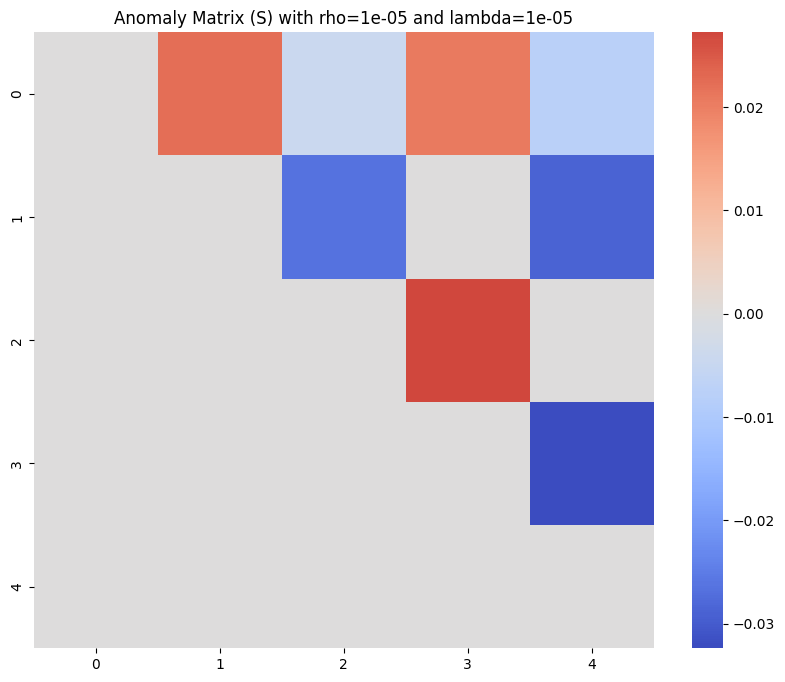

In [17]:
plt.figure(figsize=(10, 8))
sns.heatmap(S, cmap='coolwarm', center=0)
plt.title(f"Anomaly Matrix (S) with rho={best_rho} and lambda={best_lambda}")
plt.show()

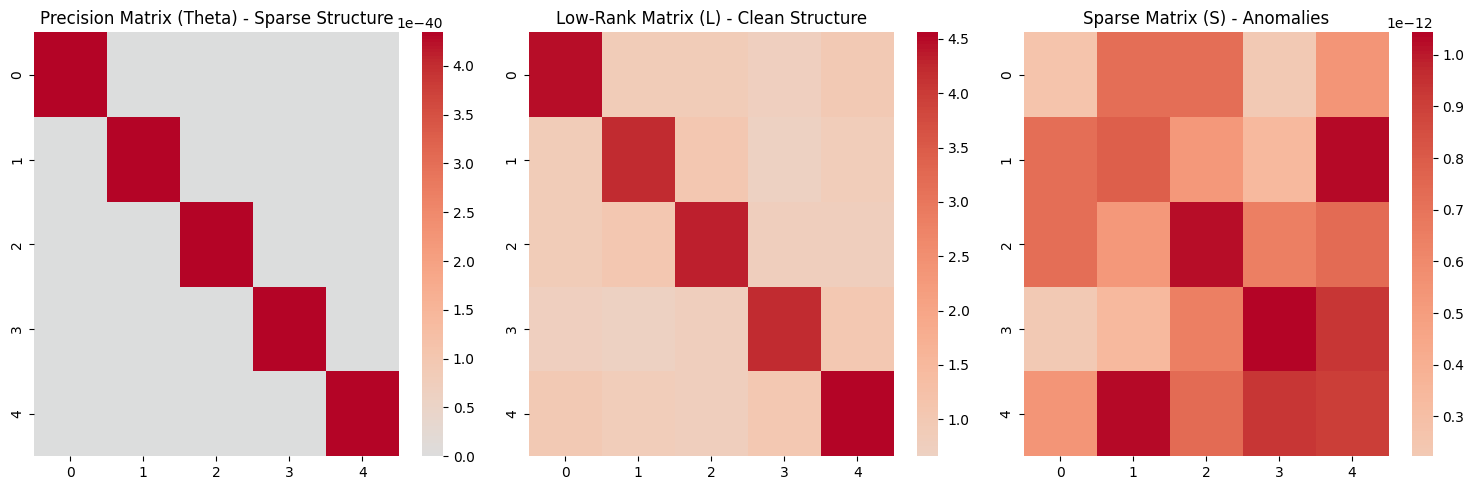

In [18]:
# Run ADMM with optimal parameters
theta_opt, S_opt, L_opt, iterations = robust_graphical_lasso(M, best_rho, best_lambda)

# Plotting the Heatmaps for Analysis
plt.figure(figsize=(15, 5))

# Precision matrix (Theta) - Conditional Dependencies
plt.subplot(1, 3, 1)
sns.heatmap(theta_opt, cmap='coolwarm', center=0)
plt.title("Precision Matrix (Theta) - Sparse Structure")

# Low-rank matrix (L) - Clean Covariance
plt.subplot(1, 3, 2)
sns.heatmap(L_opt, cmap='coolwarm', center=0)
plt.title("Low-Rank Matrix (L) - Clean Structure")

# Sparse matrix (S) - Anomalies
plt.subplot(1, 3, 3)
sns.heatmap(S_opt, cmap='coolwarm', center=0)
plt.title("Sparse Matrix (S) - Anomalies")

plt.tight_layout()
plt.show()

In [19]:
true_anomalies

array([False,  True, False,  True,  True])

In [20]:
from sklearn.covariance import MinCovDet
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

def mcd_anomaly_detection(data, true_anomalies):
    mcd = MinCovDet().fit(data)
    mahalanobis_distances = mcd.mahalanobis(data)
    threshold = np.percentile(mahalanobis_distances, 95)  # 95th percentile

    detected_anomalies = (mahalanobis_distances > threshold).astype(int)

    # Calculate metrics
    f1 = f1_score(true_anomalies, detected_anomalies)
    precision = precision_score(true_anomalies, detected_anomalies)
    recall = recall_score(true_anomalies, detected_anomalies)
    roc_auc = roc_auc_score(true_anomalies, mahalanobis_distances)

    print(f"MCD Results - F1: {f1}, Precision: {precision}, Recall: {recall}, ROC-AUC: {roc_auc}")
    return mahalanobis_distances, detected_anomalies


In [21]:
from scipy.sparse.linalg import svds
from sklearn.preprocessing import StandardScaler

def rpca(data, true_anomalies, lambda_=1.0):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # RPCA decomposition
    U, sigma, Vt = svds(data_scaled, k=10)
    L = np.dot(U, np.dot(np.diag(sigma), Vt))  # Low-rank approximation
    S = data_scaled - L  # Sparse matrix

    anomaly_scores = np.sum(np.abs(S), axis=1)
    threshold = np.percentile(anomaly_scores, 95)

    detected_anomalies = (anomaly_scores > threshold).astype(int)

    # Calculate metrics
    f1 = f1_score(true_anomalies, detected_anomalies)
    precision = precision_score(true_anomalies, detected_anomalies)
    recall = recall_score(true_anomalies, detected_anomalies)
    roc_auc = roc_auc_score(true_anomalies, anomaly_scores)

    print(f"RPCA Results - F1: {f1}, Precision: {precision}, Recall: {recall}, ROC-AUC: {roc_auc}")
    return anomaly_scores, detected_anomalies


Best Rglasso F1: 0.5714285714285714, Best rho: 1e-05, Best lambda: 1e-05
MCD: F1=0.5, Precision=1.0, Recall=0.3333333333333333
RPCA: F1=0.75, Precision=0.6, Recall=1.0


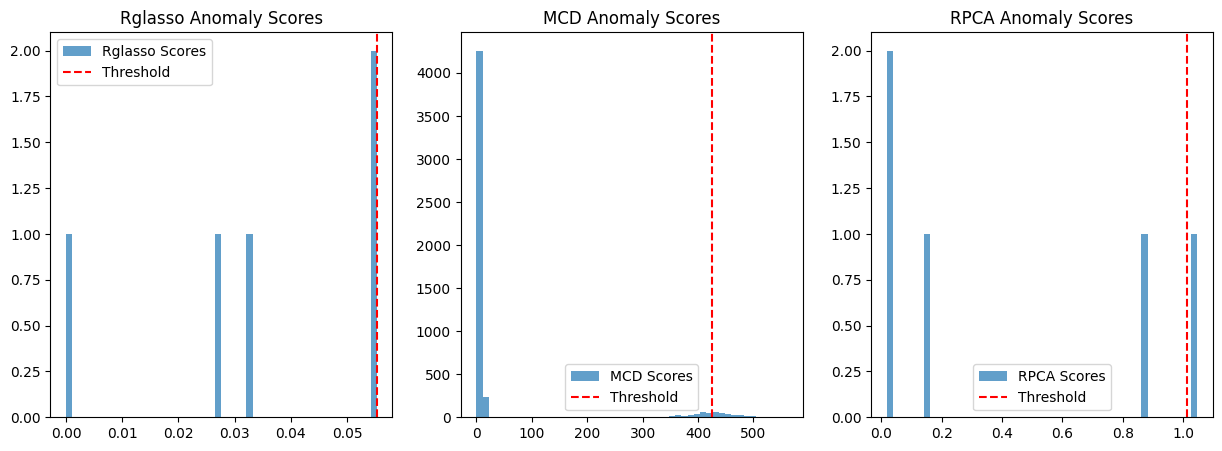

In [22]:
def evaluate_method(S, true_anomalies, anomaly_threshold=1e-9):
    # Apply refined threshold on S for detecting significant anomalies
    significant_anomalies = np.abs(S) > anomaly_threshold
    detected_anomalies = (np.any(significant_anomalies, axis=1)).astype(int)  # Row-wise check for anomalies

    # Ensure shapes match
    if detected_anomalies.shape[0] != true_anomalies.shape[0]:
        detected_anomalies = np.repeat(detected_anomalies, true_anomalies.shape[0] // detected_anomalies.shape[0])

    # Calculate metrics
    f1 = f1_score(true_anomalies, detected_anomalies)
    precision = precision_score(true_anomalies, detected_anomalies)
    recall = recall_score(true_anomalies, detected_anomalies)
    return f1, precision, recall, detected_anomalies

# Compare methods

def compare_methods(data, true_anomalies):
    # Rglasso
    best_f1_score = 0
    best_rho, best_lambda = None, None

    for rho in rho_values:
        for lambda_ in lambda_values:
            theta, S_rglasso, L, _ = robust_graphical_lasso(M_scaled, rho, lambda_)
            f1_rglasso, precision_rglasso, recall_rglasso, detected_anomalies_rglasso = evaluate_method(S_rglasso, true_anomalies)

            if f1_rglasso > best_f1_score:
                best_f1_score = f1_rglasso
                best_rho = rho
                best_lambda = lambda_

            # print(f"Rglasso: rho={rho}, lambda={lambda_}, F1={f1_rglasso}, Precision={precision_rglasso}, Recall={recall_rglasso}")

    print(f"Best Rglasso F1: {best_f1_score}, Best rho: {best_rho}, Best lambda: {best_lambda}")

    # MCD
    from sklearn.covariance import MinCovDet
    mcd = MinCovDet().fit(data)
    mahalanobis_distances = mcd.mahalanobis(data)
    threshold_mcd = np.percentile(mahalanobis_distances, 95)
    detected_anomalies_mcd = (mahalanobis_distances > threshold_mcd).astype(int)

    # Align shapes
    if detected_anomalies_mcd.shape[0] != true_anomalies.shape[0]:
        detected_anomalies_mcd = np.resize(detected_anomalies_mcd, true_anomalies.shape[0])

    f1_mcd = f1_score(true_anomalies, detected_anomalies_mcd)
    precision_mcd = precision_score(true_anomalies, detected_anomalies_mcd)
    recall_mcd = recall_score(true_anomalies, detected_anomalies_mcd)
    print(f"MCD: F1={f1_mcd}, Precision={precision_mcd}, Recall={recall_mcd}")

    # RPCA
    from scipy.sparse.linalg import svds
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    k = min(data_scaled.shape) - 1
    if k < 1:
        raise ValueError(f"`k` must be >= 1 for svds. Current k: {k}")

    U, sigma, Vt = svds(data_scaled, k=k)
    L_rpca = np.dot(U, np.dot(np.diag(sigma), Vt))  # Low-rank approximation
    S_rpca = data_scaled - L_rpca  # Sparse matrix

    # Align shapes
    if S_rpca.shape[0] != true_anomalies.shape[0]:
        S_rpca = S_rpca[:true_anomalies.shape[0], :]

    f1_rpca, precision_rpca, recall_rpca, detected_anomalies_rpca = evaluate_method(S_rpca, true_anomalies)
    print(f"RPCA: F1={f1_rpca}, Precision={precision_rpca}, Recall={recall_rpca}")

    # Visualize Results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.hist(np.sum(np.abs(S_rglasso), axis=1), bins=50, alpha=0.7, label='Rglasso Scores')
    plt.axvline(x=np.percentile(np.sum(np.abs(S_rglasso), axis=1), 95), color='r', linestyle='--', label='Threshold')
    plt.legend()
    plt.title("Rglasso Anomaly Scores")

    plt.subplot(1, 3, 2)
    plt.hist(mahalanobis_distances, bins=50, alpha=0.7, label='MCD Scores')
    plt.axvline(x=threshold_mcd, color='r', linestyle='--', label='Threshold')
    plt.legend()
    plt.title("MCD Anomaly Scores")

    plt.subplot(1, 3, 3)
    plt.hist(np.sum(np.abs(S_rpca), axis=1), bins=50, alpha=0.7, label='RPCA Scores')
    plt.axvline(x=np.percentile(np.sum(np.abs(S_rpca), axis=1), 95), color='r', linestyle='--', label='Threshold')
    plt.legend()
    plt.title("RPCA Anomaly Scores")

    plt.show()

# Call the compare_methods function
compare_methods(data, true_anomalies)
